In [207]:
# Data Preprocessing
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("/Users/jac4/CS/USvideos.csv")

# Convert 'trending_date' to datetime format (DD.MM.YY)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')
df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)

# Drop rows with invalid 'trending_date'
df = df.dropna(subset=['trending_date'])

# Replace 0 values with medians
median_likes = df['likes'].median()
df['likes'] = df['likes'].replace(0, median_likes)

median_dislikes = df['dislikes'].median()
df['dislikes'] = df['dislikes'].replace(0, median_dislikes)

median_comment = df['comment_count'].median()
df['comment_count'] = df['comment_count'].replace(0, median_comment)

# Extract temporal features
df['publish_year'] = df['publish_time'].dt.year
df['publish_month'] = df['publish_time'].dt.month
df['publish_day'] = df['publish_time'].dt.day

df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['trending_day'] = df['trending_date'].dt.day

# Sort data by video_id and trending_date
df = df.sort_values(by=['video_id', 'trending_date'])

The data preprocessing step cleans and prepares the YouTube dataset for analysis. The trending_date and publish_time columns are converted to a datetime format, making it easier to extract features like the year, month, and day. Rows with invalid trending_date values are removed to ensure the data is accurate. Missing or zero values in columns like likes, dislikes, and comment_count are replaced with the median, which helps avoid skewing the data. We also create new columns to capture the year and month of publication and trending. Finally, the data is sorted by video_id and trending_date to keep everything in order for the next LSTM steps. This gives us the insight to a video's performace over time.

In [209]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for training (Model 2)
features = ['likes', 'dislikes', 'comment_count']
target = 'views'

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Group by video_id and create sequences
sequence_length = 7  # Use 7 days of data as input
sequences = []
targets = []

for video_id, group in df.groupby('video_id'):
    data = group[features].values
    views = group[target].values
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(views[i + sequence_length])

# Convert to NumPy arrays
X = np.array(sequences)
y = np.array(targets)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model (Model 2)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, len(features))),
    tf.keras.layers.Dense(1)  # Predict views
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
test_loss1, test_mae1 = model.evaluate(X_test, y_test)
print(f"Algorithm 1 Test MAE: {test_mae1}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 175638744924160.0000 - mae: 5352026.5000 - val_loss: 182301749149696.0000 - val_mae: 5476653.0000
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 167126589505536.0000 - mae: 5454459.5000 - val_loss: 182299131904000.0000 - val_mae: 5476618.0000
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 167126102966272.0000 - mae: 5610155.5000 - val_loss: 181978166984704.0000 - val_mae: 5471405.5000
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 127141064736768.0000 - mae: 5040544.5000 - val_loss: 166769671012352.0000 - val_mae: 5189535.0000
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 124960538361856.0000 - mae: 4893501.0000 - val_loss: 60397419757568.0000 - val_mae: 3263111.5000
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 39542371385344.0000 - mae: 2680083.7500 - val_loss: 66712766513152.0000 - val_mae: 3386520.2500
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47952429056000.0000

Dataset Adjustments:
Create additional time dependent features that can be used with LSTM. Add features that capture the relationship between the video's publish time vs the video's last trending date. Expected to lower MAE by drawing the predicted trend that a video's peak viewing will occur a certain amount of time away from the publish date. Additionally add features publish hour and publish weekday to explore any correlations between the timing of the post and the potential for views.

In [212]:
# Add any missing temporal features
df['publish_hour'] = df['publish_time'].dt.hour
df['publish_weekday'] = df['publish_time'].dt.weekday

# Compute days since publish
df['days_since_publish'] = (df['trending_date'] - df['publish_time']).dt.days

# Select features for training (Model 2)
features = ['publish_hour', 'publish_weekday', 'days_since_publish', 'likes', 'dislikes', 'comment_count']
target = 'views'

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Group by video_id and create sequences
sequence_length = 7  # Use 7 days of data as input
sequences = []
targets = []

for video_id, group in df.groupby('video_id'):
    data = group[features].values
    views = group[target].values
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(views[i + sequence_length])

# Convert to NumPy arrays
X = np.array(sequences)
y = np.array(targets)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model (Model 2)
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, len(features))),
    tf.keras.layers.Dense(1)  # Predict views
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
test_loss2, test_mae2 = model.evaluate(X_test, y_test)
print(f"Algorithm 2 Test MAE: {test_mae2}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 129956508073984.0000 - mae: 4814133.0000 - val_loss: 182301631709184.0000 - val_mae: 5476651.5000
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 187137982988288.0000 - mae: 5776539.0000 - val_loss: 182279351566336.0000 - val_mae: 5476370.5000
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139122857476096.0000 - mae: 5228412.5000 - val_loss: 180666071252992.0000 - val_mae: 5451852.0000
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 138134587179008.0000 - mae: 5255539.0000 - val_loss: 152667598880768.0000 - val_mae: 4934737.0000
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94644603977728.0000 - mae: 4147412.5000 - val_loss: 77412968693760.0000 - val_mae: 3921616.0000
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 47161035194368.0000 - mae: 3103321.0000 - val_loss: 60600138858496.0000 - val_mae: 3383859.0000
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 43582601822208.0000 

Algorithm 1 Test MAE: 3370290.0
Algorithm 2 Test MAE: 3024683.25
Algorithm 1 Test MSE: 63769816334336.0
Algorithm 2 Test MSE: 53832247672832.0


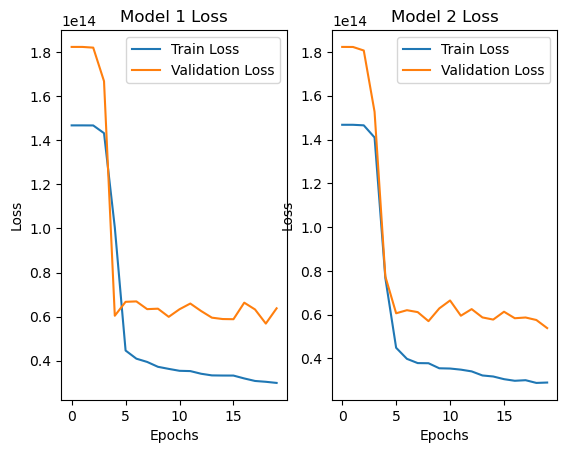

In [214]:
# Plot training & validation loss for Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')  # Model 1 loss
plt.plot(history1.history['val_loss'], label='Validation Loss')  # Model 1 validation loss
plt.title('Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation loss for Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')  # Model 2 loss
plt.plot(history2.history['val_loss'], label='Validation Loss')  # Model 2 validation loss
plt.title('Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f"Algorithm 1 Test MAE: {test_mae1}")
print(f"Algorithm 2 Test MAE: {test_mae2}")
print(f"Algorithm 1 Test MSE: {test_loss1}")
print(f"Algorithm 2 Test MSE: {test_loss2}")

Hyper-parameter Adjustments:
Increased LSTM layer size to capture more complex patterns in the data, while adding a dropout layer to prevent overfitting by regularizing the model. Chose a learning rate of 0.001 for the Adam optimizer to balance efficient training without overshooting optimal weights. Increased the number of epochs to allow enough training time, and adjusted the batch size to for practical memory usage and convergence speed. These adjustments were made to improve prediction accuracy and prevent overfitting.

In [220]:
from sklearn.metrics import r2_score

# Build the LSTM model (Model 3)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)  # Predict views
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history3 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=16)

# Evaluate the model
test_loss2, test_mae2 = model.evaluate(X_test, y_test)
print(f"Algorithm 2 Test MSE: {test_loss2}")
print(f"Algorithm 2 Test MAE: {test_mae2}")

# Make predictions
predictions = model.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, predictions)
print(f"R²: {r2}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 143033400033280.0000 - mae: 5083911.0000 - val_loss: 167401081536512.0000 - val_mae: 5244198.0000
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 86744061968384.0000 - mae: 4001160.7500 - val_loss: 71171785621504.0000 - val_mae: 3498583.0000
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 46868088225792.0000 - mae: 3037685.0000 - val_loss: 57514561372160.0000 - val_mae: 3427409.0000
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 47036640526336.0000 - mae: 3002362.0000 - val_loss: 59262814388224.0000 - val_mae: 3625257.5000
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 37805593985024.0000 - mae: 3167064.2500 - val_loss: 57879365156864.0000 - val_mae: 3430331.0000
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 39203077357568.0000 - mae: 2803364.5000 - val_loss: 66283777294336.0000 - val_mae: 3826757.2500
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 35798174924800

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


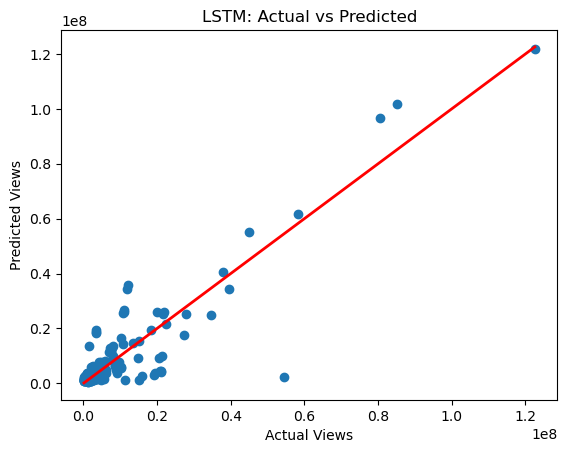

In [218]:
import matplotlib.pyplot as plt

# Predict with the tuned LSTM model
lstm_pred = model.predict(X_test)

# Plot Actual vs Predicted for LSTM
plt.scatter(y_test, lstm_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

With each improvement on the algorithm, MSE decreased from 63769816334336 to 53832247672832 to 31672154193920. This model would be greatly improved if the dataset was structured to include data from videos leading up to the trending point, as this would give the LSTM model more data points to train on. Right now, it is limited to videos with several trending days.